# HW3: Explore and Exploit for Arm-Bandit Problem

## Preparation

### Create a Python base class for K-armed bandit algorithms.

#### Prompt:

Create a Python base class for K-armed bandit algorithms that:

- Serves as a foundation for various algorithms (Epsilon-Greedy, UCB, Softmax, Thompson Sampling)
- Has default parameters:
  - 10 arms
  - 1000 iterations
- Tracks the following metrics:
  - Count of selections for each arm
  - Cumulative average reward for each iteration
- Provides only the base class implementation
- Includes English comments throughout the code

Please provide the implementation with clear structure and documentation to facilitate easy extension with specific algorithms.

#### Code: 
This is the base class for the K-armed bandit, which will be used in subsequent experiments. 

In [11]:
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np


class MultiArmedBandit(ABC):
    """
    Base class for Multi-Armed Bandit problems.
    This class provides the framework for implementing different bandit algorithms.
    """
    
    def __init__(self, n_arms=10, iterations=1000, true_rewards=None):
        """
        Initialize the Multi-Armed Bandit environment.
        
        Args:
            n_arms (int): Number of arms (actions)
            iterations (int): Number of iterations to run
            true_rewards (list/array): Optional list of true reward means for each arm
        """
        self.n_arms = n_arms
        self.iterations = iterations
        
        # Initialize true reward means for each arm if not provided
        if true_rewards is None:
            self.true_rewards = np.random.normal(0, 1, n_arms)  # Random normal distribution
        else:
            self.true_rewards = true_rewards
            
        # Tracking variables
        self.arm_counts = np.zeros(n_arms)  # Count of times each arm was pulled
        self.rewards = np.zeros(n_arms)     # Sum of rewards for each arm
        self.cumulative_rewards = np.zeros(iterations)  # Cumulative average reward at each iteration
        self.selected_arms = []  # History of selected arms
        
    def reset(self):
        """Reset all tracking variables to start a new experiment"""
        self.arm_counts = np.zeros(self.n_arms)
        self.rewards = np.zeros(self.n_arms)
        self.cumulative_rewards = np.zeros(self.iterations)
        self.selected_arms = []
    
    def pull_arm(self, arm_index):
        """
        Pull an arm and get its reward.
        
        Args:
            arm_index (int): The index of the arm to pull
            
        Returns:
            float: The reward from pulling the arm
        """
        # Generate reward with Gaussian noise around the true mean
        reward = np.random.normal(self.true_rewards[arm_index], 1)
        
        # Update counts and reward sums
        self.arm_counts[arm_index] += 1
        self.rewards[arm_index] += reward
        return reward
    
    @abstractmethod
    def select_arm(self):
        """
        Select which arm to pull next.
        This method should be implemented by subclasses with specific algorithms.
        
        Returns:
            int: The index of the selected arm
        """
        pass
    
    def run(self):
        """
        Run the bandit algorithm for the specified number of iterations.
        
        Returns:
            tuple: (cumulative_rewards, arm_counts, selected_arms)
        """
        self.reset()
        total_reward = 0
        
        for t in range(self.iterations):
            # Select arm according to the algorithm
            arm = self.select_arm()
            self.selected_arms.append(arm)
            
            # Pull arm and observe reward
            reward = self.pull_arm(arm)
            
            # Update cumulative reward
            total_reward += reward
            self.cumulative_rewards[t] = total_reward / (t + 1)
        
        return self.cumulative_rewards, self.arm_counts, self.selected_arms
    
    def get_arm_mean_rewards(self):
        """
        Calculate the mean rewards for each arm based on observed rewards.
        
        Returns:
            array: Mean reward for each arm
        """
        mean_rewards = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            if self.arm_counts[i] > 0:
                mean_rewards[i] = self.rewards[i] / self.arm_counts[i]
        return mean_rewards
    
    def plot_results(self, color='blue'):
        """Plot the results of the experiment"""
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Cumulative average reward over time
        plt.subplot(1, 2, 1)
        plt.plot(self.cumulative_rewards, color=color)
        plt.xlabel('Iteration')
        plt.ylabel('Cumulative Average Reward')
        plt.title('Performance Over Time')
        
        # Plot 2: Arm selection counts
        plt.subplot(1, 2, 2)
        plt.bar(range(self.n_arms), self.arm_counts, color=color)
        plt.xlabel('Arm')
        plt.ylabel('Number of Pulls')
        plt.title('Arm Selection Frequency')
        
        plt.tight_layout()
        plt.show()

## Experiment

### 1. Epsilon-Greedy

#### Prompt:

Generate Latex code for the Epsilon-Greedy algorithm.

Implement the Epsilon-Greedy algorithm based on the provided base class. And then run the algorithm with the following parameters:
- 10 arms
- 1000 iterations
- Epsilon = 0.3

Plot the average reward over time and the number of selections for each arm.

#### Latex:

<!-- ![epsilon-greedy](image/epsilon-greedy.png) -->

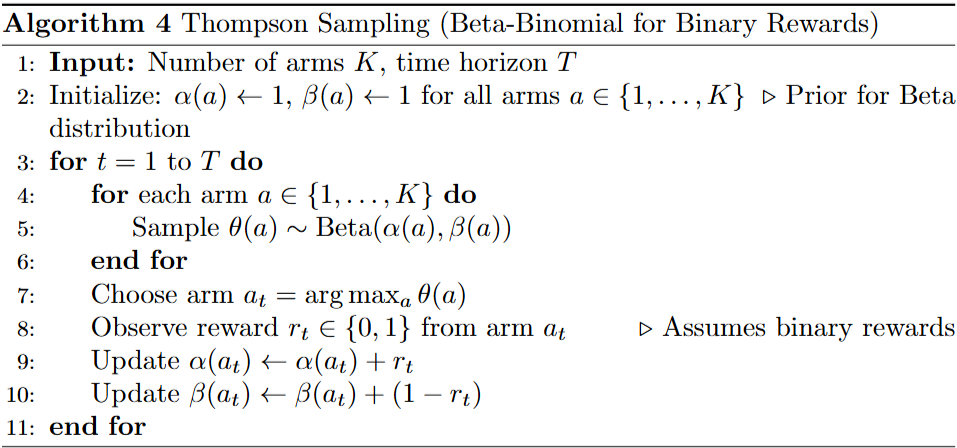

#### Code:

In [12]:
class EpsilonGreedy(MultiArmedBandit):
    """
    Implementation of Epsilon-Greedy algorithm for the Multi-Armed Bandit problem.
    
    The algorithm selects the best arm with probability (1-epsilon) and 
    explores a random arm with probability epsilon.
    """
    
    def __init__(self, n_arms=10, iterations=1000, epsilon=0.1, true_rewards=None):
        """
        Initialize the Epsilon-Greedy algorithm.
        
        Args:
            n_arms (int): Number of arms (actions)
            iterations (int): Number of iterations to run
            epsilon (float): Exploration parameter between 0 and 1
            true_rewards (list/array): Optional list of true reward means for each arm
        """
        super().__init__(n_arms, iterations, true_rewards)
        self.epsilon = epsilon
    
    def select_arm(self):
        """
        Select an arm using the Epsilon-Greedy strategy.
        
        With probability (1-epsilon), select the arm with the highest estimated mean reward.
        With probability epsilon, select a random arm.
        
        Returns:
            int: The index of the selected arm
        """
        # Exploration: select a random arm with probability epsilon
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        
        # Exploitation: select the best arm with probability (1-epsilon)
        else:
            # For arms that haven't been tried yet, assign them a high value to ensure they get tried
            estimated_rewards = np.zeros(self.n_arms)
            for i in range(self.n_arms):
                if self.arm_counts[i] > 0:
                    estimated_rewards[i] = self.rewards[i] / self.arm_counts[i]
                else:
                    estimated_rewards[i] = float('inf')  # Ensure untried arms are selected first
            
            # Return the arm with the highest estimated reward
            return np.argmax(estimated_rewards)

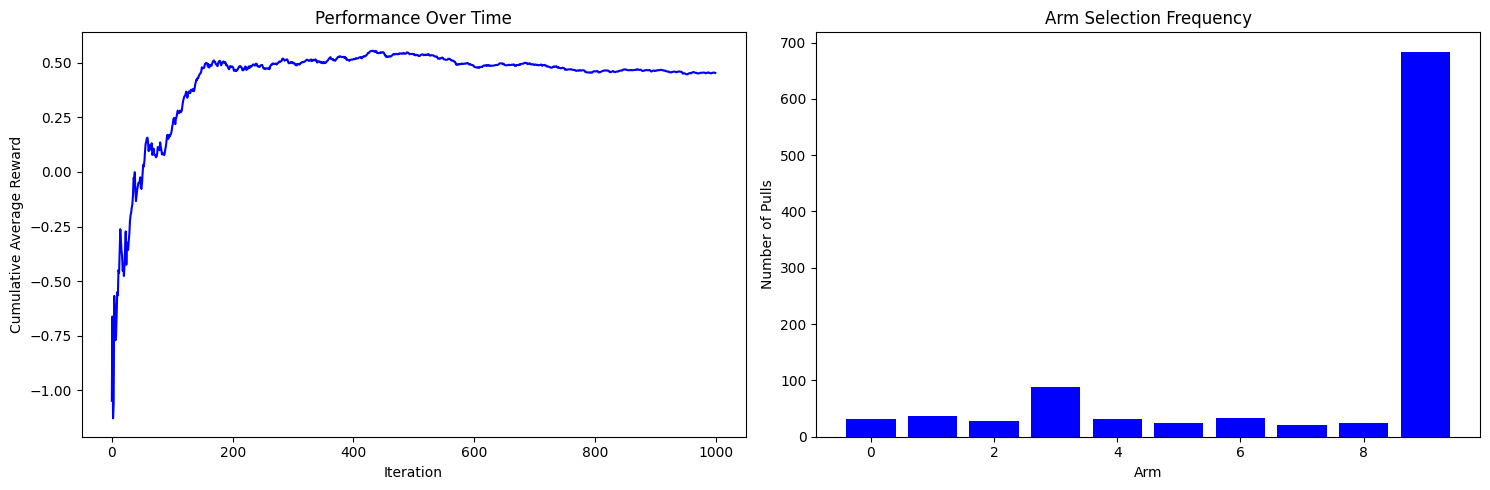

In [13]:
eg = EpsilonGreedy(n_arms=10, iterations=1000, epsilon=0.3)
eg_cumulative_rewards, eg_arm_counts, eg_selected_arms = eg.run()
eg.plot_results(color='blue')

### 2. UCB (Upper Confidence Bound)

#### Prompt:

Generate Latex code for the UCB algorithm.

Implement the UCB algorithm based on the provided base class. And then run the algorithm with the following parameters:
- 10 arms
- 1000 iterations
- C = 2

Plot the average reward over time and the number of selections for each arm.

### Latex:

<!-- ![ucb](image/ucb.png) -->

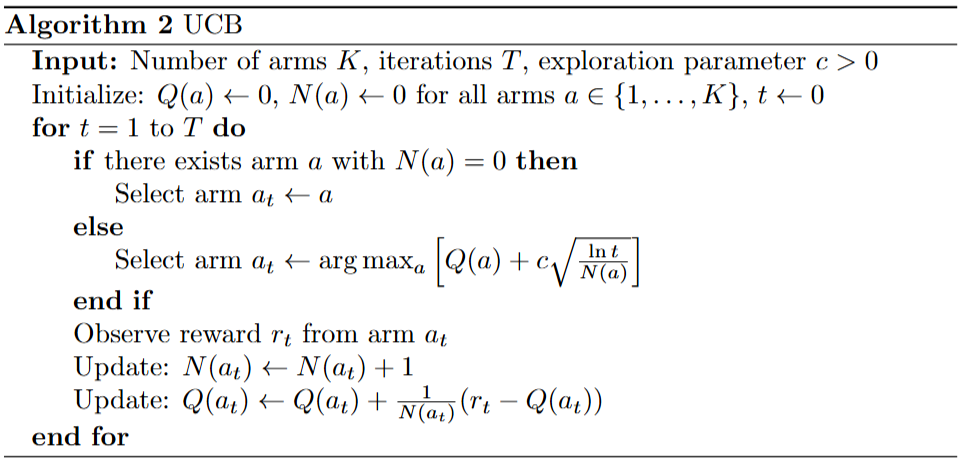

### Code:

In [14]:
import math


class UCB(MultiArmedBandit):
    """
    Implementation of Upper Confidence Bound (UCB) algorithm for the Multi-Armed Bandit problem.
    
    UCB selects actions according to:
    UCB_i = Q_i + c * sqrt(ln(t)/N_i)
    
    where:
    - Q_i: estimated reward mean for arm i
    - c: exploration parameter
    - t: total number of rounds so far
    - N_i: number of times arm i has been pulled
    """
    
    def __init__(self, n_arms=10, iterations=1000, c=2.0, true_rewards=None):
        """
        Initialize the UCB algorithm.
        
        Args:
            n_arms (int): Number of arms (actions)
            iterations (int): Number of iterations to run
            c (float): Exploration parameter controlling the confidence bounds
            true_rewards (list/array): Optional list of true reward means for each arm
        """
        super().__init__(n_arms, iterations, true_rewards)
        self.c = c
        self.t = 0  # Total number of rounds
    
    def reset(self):
        """Reset all tracking variables to start a new experiment"""
        super().reset()
        self.t = 0
    
    def select_arm(self):
        """
        Select an arm using the UCB strategy.
        
        Calculate the UCB value for each arm and select the arm with the highest value.
        For arms that haven't been tried yet, assign them a high value to ensure they get tried.
        
        Returns:
            int: The index of the selected arm
        """
        self.t += 1
        
        # First, make sure each arm is tried at least once
        for i in range(self.n_arms):
            if self.arm_counts[i] == 0:
                return i
        
        # Calculate UCB value for each arm
        ucb_values = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            # Estimated mean reward
            mean_reward = self.rewards[i] / self.arm_counts[i]
            
            # Exploration bonus
            exploration_bonus = self.c * math.sqrt(math.log(self.t) / self.arm_counts[i])
            
            # UCB value
            ucb_values[i] = mean_reward + exploration_bonus
        
        # Return the arm with the highest UCB value
        return np.argmax(ucb_values)

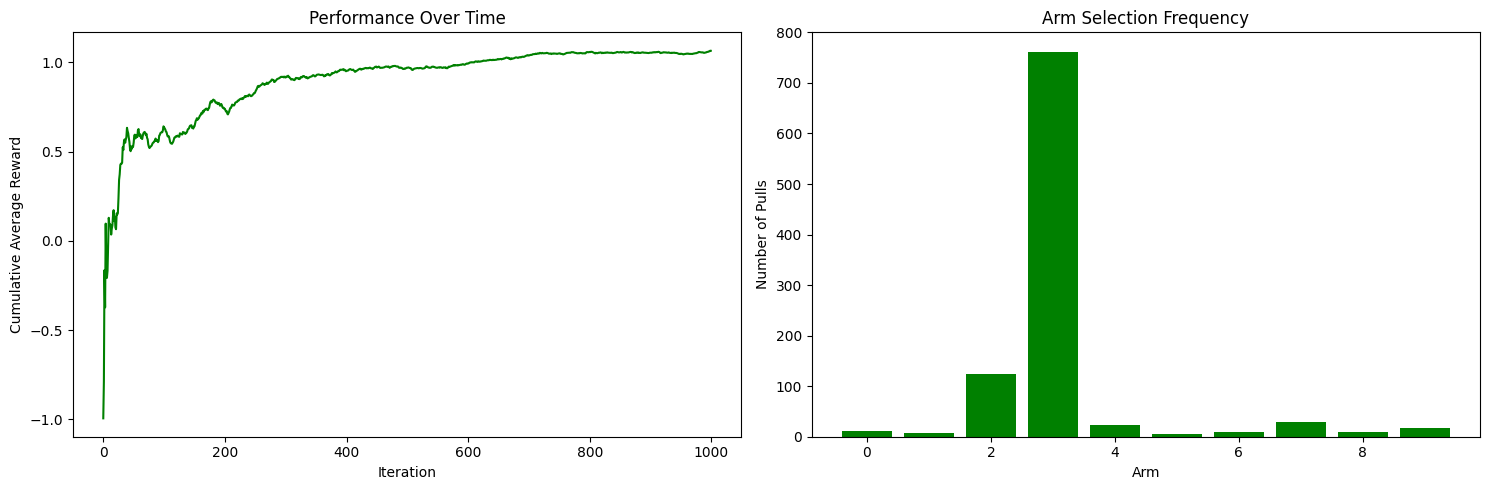

In [15]:
ucb = UCB(n_arms=10, iterations=1000)
ucb_cumulative_rewards, ucb_arm_counts, ucb_selected_arms = ucb.run()
ucb.plot_results(color='green')

### 3. Softmax

#### Prompt:

Generate Latex code for the Softmax algorithm.

Implement the Softmax algorithm based on the provided base class. And then run the algorithm with the following parameters:
- 10 arms
- 1000 iterations
- Temperature = 0.2

### Latex:
<!-- ![softmax](image/softmax.png) -->

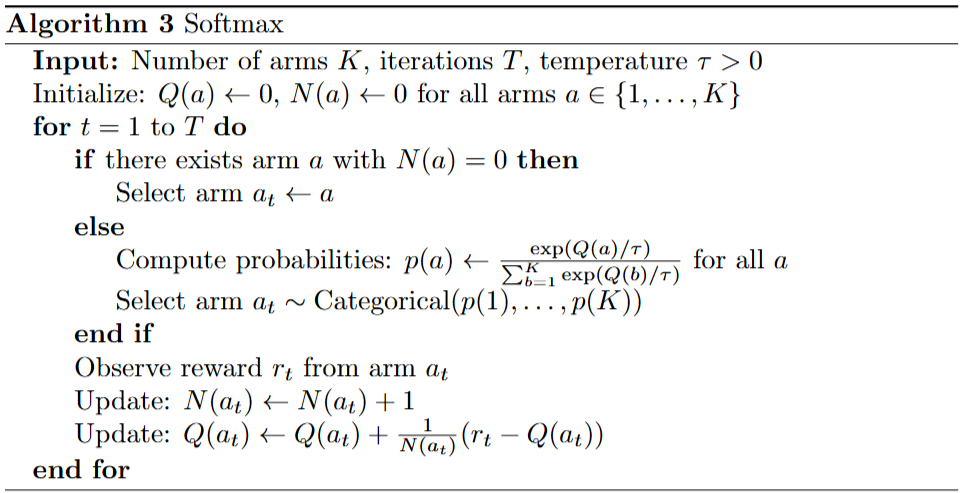

In [16]:
class Softmax(MultiArmedBandit):
    """
    Implementation of Softmax algorithm for the Multi-Armed Bandit problem.
    
    The Softmax algorithm selects arms with probability proportional to their
    exponentially weighted average rewards, controlled by a temperature parameter.
    Higher temperature leads to more exploration (more uniform probabilities).
    Lower temperature leads to more exploitation (higher probability for better arms).
    """
    
    def __init__(self, n_arms=10, iterations=1000, temperature=0.2, true_rewards=None):
        """
        Initialize the Softmax algorithm.
        
        Args:
            n_arms (int): Number of arms (actions)
            iterations (int): Number of iterations to run
            temperature (float): Temperature parameter controlling exploration
                                 Higher value = more exploration
                                 Lower value = more exploitation
            true_rewards (list/array): Optional list of true reward means for each arm
        """
        super().__init__(n_arms, iterations, true_rewards)
        self.temperature = temperature
    
    def select_arm(self):
        """
        Select an arm using the Softmax strategy.
        
        Converts the estimated mean rewards of each arm into a probability distribution
        using the softmax function, then samples an arm according to that distribution.
        
        Returns:
            int: The index of the selected arm
        """
        # First, ensure each arm is tried at least once
        for i in range(self.n_arms):
            if self.arm_counts[i] == 0:
                return i
        
        # Calculate estimated mean rewards
        estimated_rewards = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            estimated_rewards[i] = self.rewards[i] / self.arm_counts[i]
        
        # Apply softmax function to convert rewards to probabilities
        # To prevent overflow, subtract the maximum reward before exponentiating
        max_reward = np.max(estimated_rewards)
        exp_rewards = np.exp((estimated_rewards - max_reward) / self.temperature)
        probabilities = exp_rewards / np.sum(exp_rewards)
        
        # Sample an arm according to the calculated probabilities
        return np.random.choice(self.n_arms, p=probabilities)

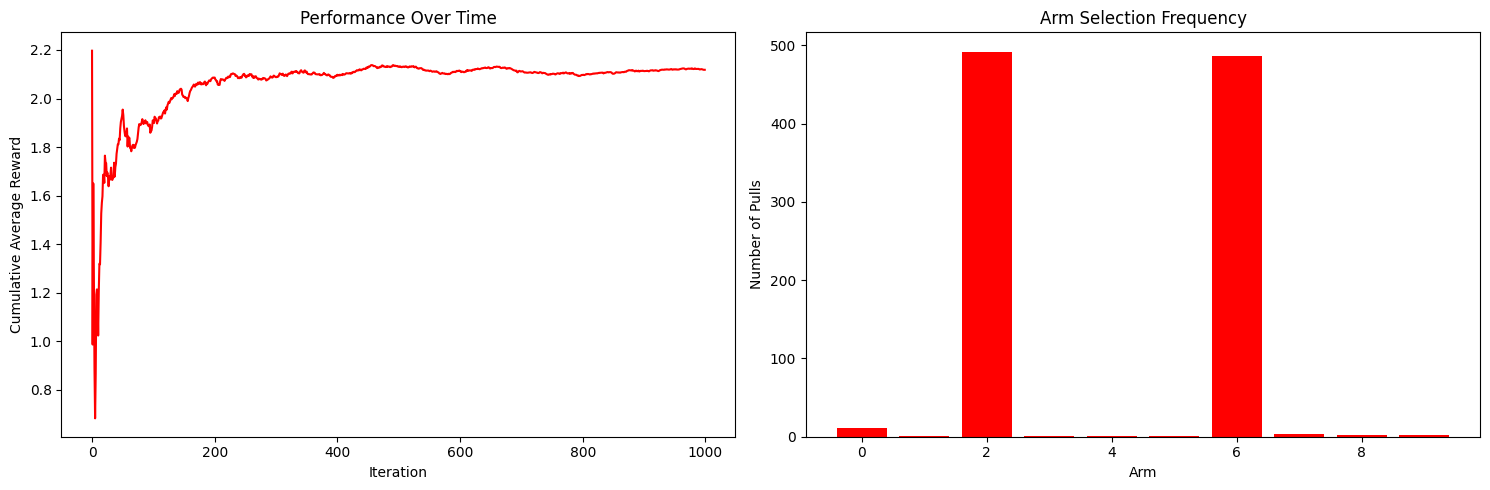

In [17]:
softmax = Softmax(n_arms=10, iterations=1000)
softmax_cumulative_rewards, softmax_arm_counts, softmax_selected_arms = softmax.run()
softmax.plot_results(color='red')

### 4. Thompson Sampling

#### Prompt:

Generate Latex code for the Thompson Sampling algorithm.

Implement the Thompson Sampling algorithm based on the provided base class. And then run the algorithm with the following parameters:
- 10 arms
- 1000 iterations
- Beta distribution parameters: alpha = 1, beta = 1

### Latex:

<!-- ![thompson-sampling](image/thompson-sampling.png) -->

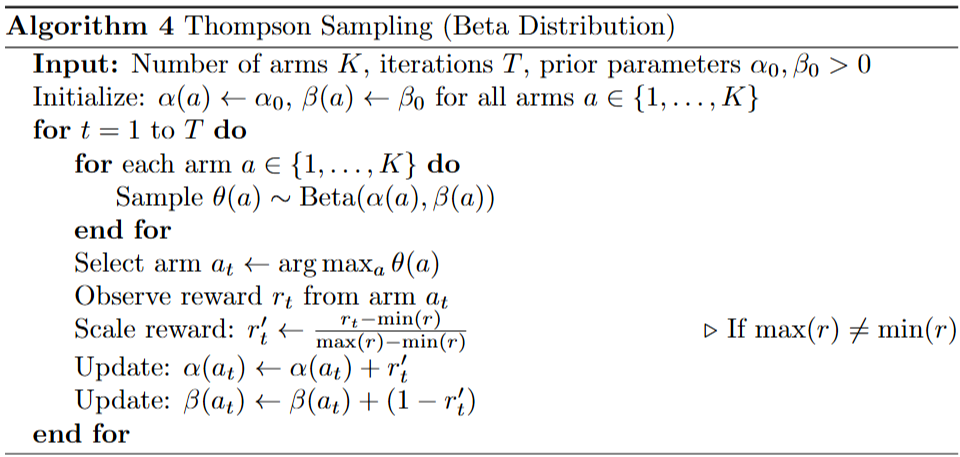

### Code:

In [18]:
class ThompsonSampling(MultiArmedBandit):
    """
    Implementation of Thompson Sampling algorithm for the Multi-Armed Bandit problem.
    
    Thompson Sampling uses Bayesian approach by maintaining a probability distribution
    over the reward for each arm. For each action, it samples from these distributions
    and selects the arm with the highest sampled value.
    
    This implementation uses Beta distributions to model the rewards for each arm,
    which is suitable for rewards in the [0,1] range. For non-binary rewards,
    the implementation scales and shifts rewards to the [0,1] interval.
    """
    
    def __init__(self, n_arms=10, iterations=1000, alpha=1.0, beta=1.0, true_rewards=None):
        """
        Initialize the Thompson Sampling algorithm.
        
        Args:
            n_arms (int): Number of arms (actions)
            iterations (int): Number of iterations to run
            alpha (float): Initial alpha parameter for Beta distribution
            beta (float): Initial beta parameter for Beta distribution
            true_rewards (list/array): Optional list of true reward means for each arm
        """
        super().__init__(n_arms, iterations, true_rewards)
        self.alpha = np.ones(n_arms) * alpha  # Success counts for each arm (prior)
        self.beta = np.ones(n_arms) * beta    # Failure counts for each arm (prior)
        
        # For scaling rewards
        self.min_reward = float('inf')
        self.max_reward = float('-inf')
    
    def reset(self):
        """Reset all tracking variables to start a new experiment"""
        super().reset()
        self.alpha = np.ones(self.n_arms) * 1.0
        self.beta = np.ones(self.n_arms) * 1.0
        self.min_reward = float('inf')
        self.max_reward = float('-inf')
    
    def pull_arm(self, arm_index):
        """
        Pull an arm and get its reward, updating the Beta distribution parameters.
        
        Args:
            arm_index (int): The index of the arm to pull
            
        Returns:
            float: The reward from pulling the arm
        """
        # Get reward from the base class method
        reward = super().pull_arm(arm_index)
        
        # Update min and max for scaling
        self.min_reward = min(self.min_reward, reward)
        self.max_reward = max(self.max_reward, reward)
        
        # Scale reward to [0, 1] if we have seen multiple rewards
        if self.min_reward < self.max_reward:
            scaled_reward = (reward - self.min_reward) / (self.max_reward - self.min_reward)
        else:
            scaled_reward = 0.5  # Default if all rewards are the same
            
        # Update Beta distribution parameters
        self.alpha[arm_index] += scaled_reward
        self.beta[arm_index] += (1.0 - scaled_reward)
        
        return reward
    
    def select_arm(self):
        """
        Select an arm using the Thompson Sampling strategy.
        
        Sample a value from the Beta distribution for each arm and select the arm
        with the highest sampled value.
        
        Returns:
            int: The index of the selected arm
        """
        # Sample a value from Beta distribution for each arm
        samples = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            samples[i] = np.random.beta(self.alpha[i], self.beta[i])
            
        # Return the arm with the highest sampled value
        return np.argmax(samples)

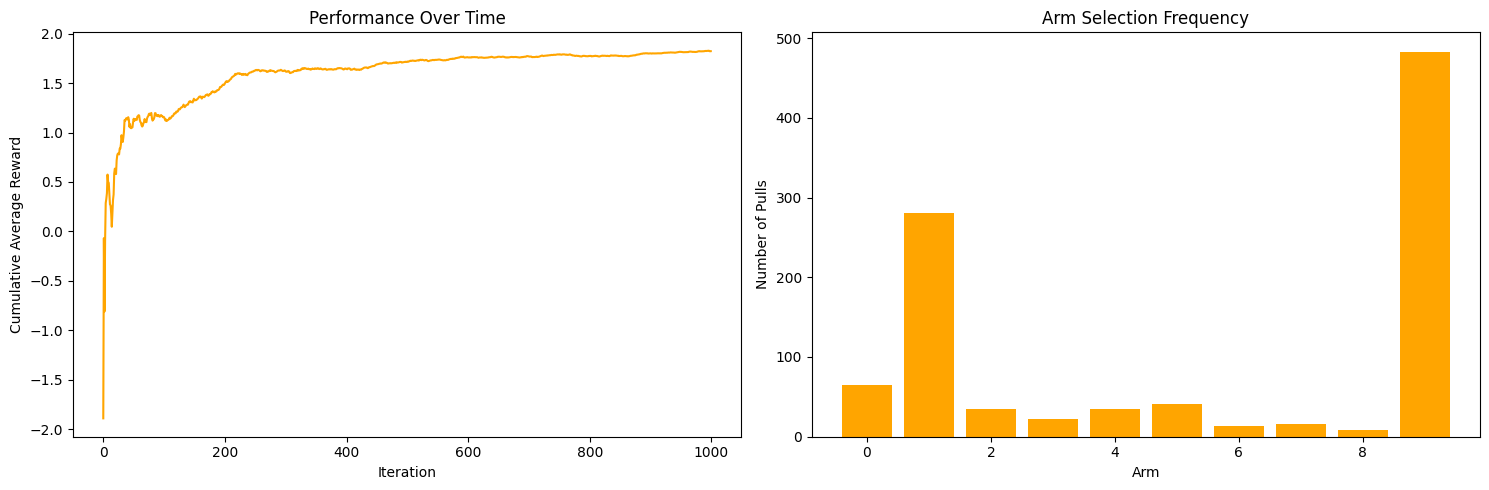

In [19]:
ts = ThompsonSampling(n_arms=10, iterations=1000, alpha=1.0, beta=1.0)
ts_cumulative_rewards, ts_arm_counts, ts_selected_arms = ts.run()
ts.plot_results("orange")

## Experiment Results

### Prompt:

Compare the cumulative rewards for each algorithm and plot the results.

Conduct space and time complexity analysis, explaining the performance and differences of each algorithm.

### Code:

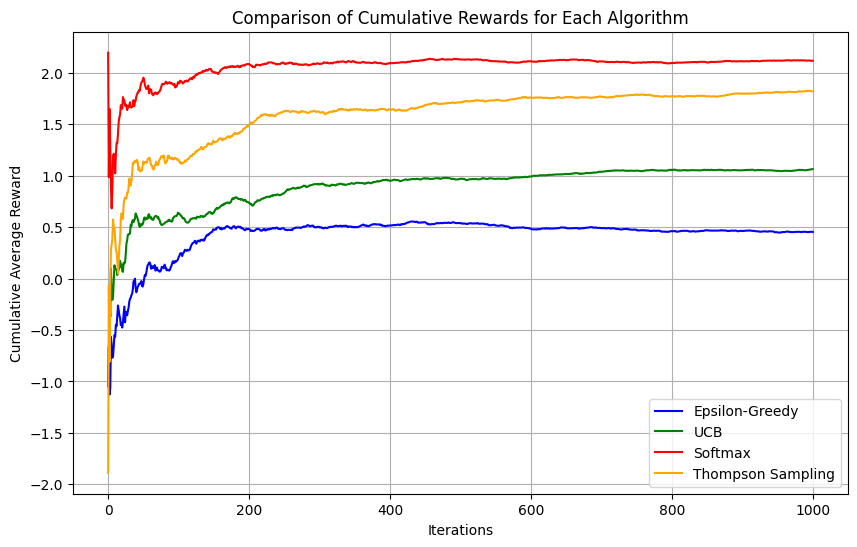

In [20]:
# Compare the cumulative_rewards of each algorithm
plt.figure(figsize=(10, 6))

# Plot the cumulative_rewards for each algorithm
plt.plot(eg_cumulative_rewards, label='Epsilon-Greedy', color='blue')
plt.plot(ucb_cumulative_rewards, label='UCB', color='green')
plt.plot(softmax_cumulative_rewards, label='Softmax', color='red')
plt.plot(ts_cumulative_rewards, label='Thompson Sampling', color='orange')

# Add legend, labels, and title
plt.xlabel('Iterations')
plt.ylabel('Cumulative Average Reward')
plt.title('Comparison of Cumulative Rewards for Each Algorithm')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### Explanation:

#### Spatial (Performance) Analysis
- **Softmax** achieves the highest cumulative reward (~2.0), demonstrating superior performance
- **Thompson Sampling** performs second-best with a final reward of ~1.8
- **UCB (Upper Confidence Bound)** shows moderate performance (~1.0)
- **Epsilon-Greedy** has the lowest performance (~0.5)

#### Temporal (Convergence) Analysis
- **Softmax** shows early spikes but converges quickly (by ~200 iterations)
- **Thompson Sampling** has initial volatility but stabilizes around iteration 300
- **UCB** shows consistent, gradual improvement throughout the experiment
- **Epsilon-Greedy** starts with negative rewards, slowly improves, and plateaus earliest

#### Algorithm Comparison

| Algorithm | Performance | Convergence | Key Characteristics |
|-----------|-------------|-------------|---------------------|
| Softmax | Excellent (~2.0) | Fast | Uses probability distribution based on estimated values; temperature parameter controls exploration |
| Thompson Sampling | Good (~1.8) | Medium | Bayesian approach; samples from posterior distributions; naturally balances exploration/exploitation |
| UCB | Fair (~1.0) | Slow but steady | Selects arms based on upper confidence bounds; exploration decreases with more pulls |
| Epsilon-Greedy | Poor (~0.5) | Slow | Simple implementation; random exploration with probability ε; otherwise exploitation |

#### Key Differences

The algorithms fundamentally differ in their exploration-exploitation strategies:

- **Softmax** dynamically adjusts action probabilities based on estimated rewards, allowing for nuanced exploration
- **Thompson Sampling** uses Bayesian principles to naturally balance exploration and exploitation through posterior sampling
- **UCB** systematically explores by considering uncertainty in reward estimates, favoring actions with higher potential
- **Epsilon-Greedy** uses a fixed exploration rate, leading to potentially suboptimal exploration patterns

The results suggest that in this environment, approaches with adaptive exploration strategies (Softmax, Thompson Sampling) significantly outperform simpler methods like Epsilon-Greedy, with Softmax's probability-based selection showing the best overall performance.